# 1.1 

## Modules

In [1]:
import gymnasium as gym
import numpy as np
import torch
from stable_baselines3 import SAC
import matplotlib.pyplot as plt
import numpy as np

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
GAMMA = 0.99
LR = 1e-4
BATCH_SIZE = 64
    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
def rollout_sb3(env, model, seed=0, max_steps=500):
    """Rollout function for stable_baselines3 SAC model"""
    state, _ = env.reset(seed=seed)
    done = False
    step = 0

    states = []
    actions = []

    while not done and step < max_steps:
        action, _ = model.predict(state, deterministic=True)
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        states.append(state)
        actions.append(action)
        step += 1

    return np.array(states), np.array(actions)

# Injecting Gaussian Noise

## Initialize

In [4]:
class ActionGaussianNoiseWrapper(gym.Wrapper):
    def __init__(self, env, snr_linear=20.0):
        super().__init__(env)
        self.snr_linear = snr_linear

    def step(self, action):
        # action shape: (1,)
        signal_power = np.mean(action**2) + 1e-8

        # Noise power from SNR definition
        noise_power = signal_power / self.snr_linear
        noise_std = np.sqrt(noise_power)

        noise = np.random.normal(0.0, noise_std, size=action.shape)
        action_noisy = action + noise

        return self.env.step(action_noisy)


In [5]:
env = gym.make("Pendulum-v1")
env = ActionGaussianNoiseWrapper(env, snr_linear=0.5)

In [6]:
# Create SAC model for baseline (noisy environment)
model = SAC(
    "MlpPolicy",
    env,
    learning_rate=3e-4,
    gamma=0.99,
    # verbose=1,
)

## Training

In [7]:
# Train the baseline SAC model
model.learn(total_timesteps=80_000)

# Reducing Noise 

## Initialise

In [38]:
from scipy.signal import butter, lfilter, lfilter_zi

class BandLimitedRewardWrapper(gym.Wrapper):
    def __init__(
        self,
        env,
        fs=20.0, # sampling frequency of Pendulum-v1 = 1/0.05s
        cutoff_hz=6.0,
        lambda_lpf=0.1, 
        lambda_w=0.01
    ):
        super().__init__(env)

        self.lambda_lpf = lambda_lpf
        self.lambda_w = lambda_w

        nyq = 0.5 * fs
        self.b, self.a = butter(2, cutoff_hz / nyq, btype="low")
        self.zi = lfilter_zi(self.b, self.a)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.zi = lfilter_zi(self.b, self.a)
        return obs, info

    def step(self, action):
        u = float(action[0])
        action_env = np.array([u], dtype=np.float32)


        obs, reward, terminated, truncated, info = self.env.step(action_env)


        u_lpf, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_lpf = u_lpf[0]

        # ---- penalties ----
        band_penalty = -self.lambda_lpf * (u - u_lpf)**2

        _, _, theta_dot = obs
        vel_penalty = -self.lambda_w * theta_dot**2

        reward += band_penalty + vel_penalty

        return obs, reward, terminated, truncated, info


In [39]:
# Create environment with band-limited reward
env_smooth = gym.make("Pendulum-v1")
env_smooth = ActionGaussianNoiseWrapper(env_smooth, snr_linear=0.5)
env_smooth = BandLimitedRewardWrapper(
    env_smooth,
    cutoff_hz=6.0,
    lambda_lpf=0.1,
    lambda_w=0.01
)

In [40]:
# Create SAC model for smooth environment (band-limited reward)
model_smooth = SAC(
    "MlpPolicy",
    env_smooth,
    learning_rate=3e-4,
    gamma=0.99,
    # verbose=1,
)

## Training

In [41]:
model_smooth.learn(total_timesteps=80_000)

# Evaluate

In [42]:
# Create evaluation environment (noisy env for comparison)
env_eval_noise = gym.make("Pendulum-v1")
env_eval_noise = ActionGaussianNoiseWrapper(env_eval_noise, snr_linear=0.5)

In [43]:
states_base, actions_base = rollout_sb3(
    env_eval_noise,
    model,          # baseline noisy SAC
    seed=42
)

states_smooth, actions_smooth = rollout_sb3(
    env_eval_noise,
    model_smooth,   # band-limited reward SAC
    seed=42
)

In [44]:
N = min(len(actions_base), len(actions_smooth))

states_base = states_base[:N]
actions_base = actions_base[:N]

states_smooth = states_smooth[:N]
actions_smooth = actions_smooth[:N]


In [45]:
def extract_signals(states, actions):
    theta = np.arctan2(states[:, 1], states[:, 0])
    theta_dot = states[:, 2]
    u = actions[:, 0]

    # remove DC
    theta -= np.mean(theta)
    theta_dot -= np.mean(theta_dot)
    u -= np.mean(u)

    return theta, theta_dot, u


In [46]:
theta_b, theta_dot_b, u_b = extract_signals(states_base, actions_base)
theta_s, theta_dot_s, u_s = extract_signals(states_smooth, actions_smooth)

dt = env_eval_noise.unwrapped.dt
freqs = np.fft.fftfreq(N, d=dt)
mask = freqs > 0

def compute_fft(x):
    return np.fft.fft(x)

fft_u_b = compute_fft(u_b)
fft_u_s = compute_fft(u_s)

fft_th_b = compute_fft(theta_b)
fft_th_s = compute_fft(theta_s)


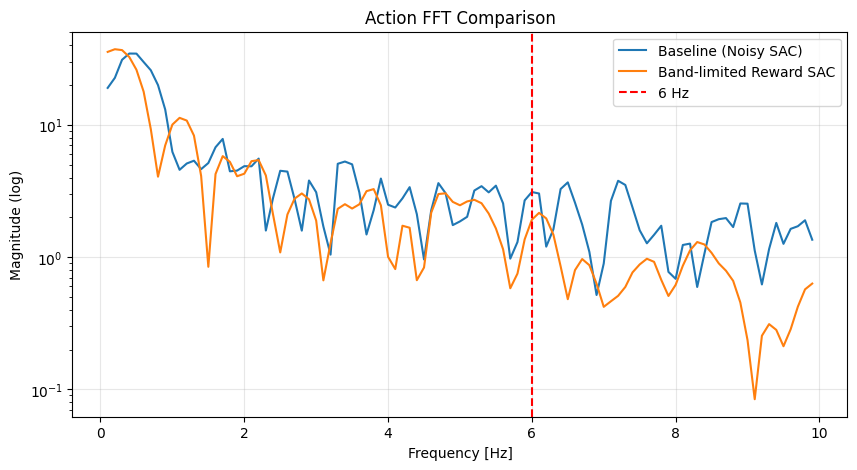

In [47]:
plt.figure(figsize=(10, 5))
plt.semilogy(freqs[mask], np.abs(fft_u_b[mask]), label="Baseline (Noisy SAC)")
plt.semilogy(freqs[mask], np.abs(fft_u_s[mask]), label="Band-limited Reward SAC")
plt.axvline(6.0, color="r", linestyle="--", label="6 Hz")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude (log)")
plt.title("Action FFT Comparison")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


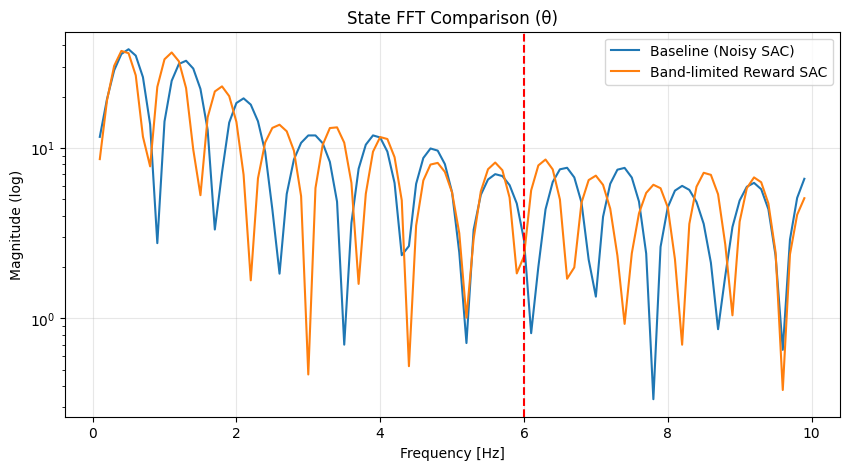

In [48]:
plt.figure(figsize=(10, 5))
plt.semilogy(freqs[mask], np.abs(fft_th_b[mask]), label="Baseline (Noisy SAC)")
plt.semilogy(freqs[mask], np.abs(fft_th_s[mask]), label="Band-limited Reward SAC")
plt.axvline(6.0, color="r", linestyle="--")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude (log)")
plt.title("State FFT Comparison (θ)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
